# Machine Learning Foundation

## Section 2, Part c: Cross Validation 

## Learning objectives

By the end of this lesson, you will be able to:

* Chain multiple data processing steps together using `Pipeline`
* Use the `KFolds` object to split data into multiple folds.
* Perform cross validation using SciKit Learn with `cross_val_predict` and `GridSearchCV`


In [ ]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
# Laso and Ridge are linear regression models that ensure that there is no over-fitting 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import files 
files.upload()

{}

## Upload the file
Use files.upload to upload file and then open it  

In [ ]:
# Note we are loading a slightly different ("cleaned") pickle file
boston = pickle.load(open('/content/boston_housing_cleaned.pickle', "rb" ))

## Reading the dataframe from the file : 
Read the dataframe and explore it 

In [ ]:
boston.keys()

dict_keys(['dataframe', 'description'])

In [ ]:
boston_data = boston['dataframe']
boston_description = boston['description']

In [ ]:
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Discussion: 

Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset. 

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

We use k-fold for data splitting to multiple data-sets and then test on each portion òf the data



```
# This is formatted as code
```

#### Coding this up

The [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [ ]:
X = boston_data.drop('MEDV', axis=1)
y = boston_data.MEDV

In [ ]:
X.shape

(506, 13)

for only 3 splits (where the test sample is one third and can not be duplicated ) and we will have 3 splits ò training and testing sampples 

In [ ]:
# create object 
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [ ]:
kf.split(X)

<generator object _BaseKFold.split at 0x7f9294290d00>

In [ ]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[0:10], len(train_index))
    print("Test index:", test_index[0:10], len(test_index))
    print('')

Train index: [ 1  3  4  5  7  8 10 11 12 13] 337
Test index: [ 0  2  6  9 15 17 19 23 25 26] 169

Train index: [ 0  2  6  9 10 11 12 13 15 17] 337
Test index: [ 1  3  4  5  7  8 14 16 22 27] 169

Train index: [0 1 2 3 4 5 6 7 8 9] 338
Test index: [10 11 12 13 18 20 21 24 28 31] 168



In [ ]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
# create a predictor object 
lr = LinearRegression()
# loop for each split : 
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    # fit the mpodel 
    lr.fit(X_train, y_train)
    # predict     
    y_pred = lr.predict(X_test)
     # evaluate using r2 score 
    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.6719348798472724, 0.7485020059212374, 0.6976807323597793]

A bit cumbersome, but do-able.

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

**Your response below**

### Coding this up

In [ ]:
scores = []

lr = LinearRegression()
# standard scaler object 
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :],  # all columns of x_train
                                        X.iloc[test_index, :],    # all columns of x_test
                                        y[train_index], 
                                        y[test_index])
    # standard scaling for training set
    X_train_s = s.fit_transform(X_train)
    lr.fit(X_train_s, y_train)

    # standard scaling for testing set 
    X_test_s = s.transform(X_test)
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [ ]:
scores

[0.6719348798472715, 0.7485020059212382, 0.6976807323597745]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

`Pipeline` lets you chain together multiple operators on your data that both have a `fit` method.

In [ ]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a `Pipeline`

A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.  
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [ ]:
# (name òf the step , object name)
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

In [ ]:
test_index

array([ 10,  11,  12,  13,  18,  20,  21,  24,  28,  31,  36,  37,  42,
        43,  45,  47,  48,  51,  52,  55,  58,  60,  61,  65,  67,  68,
        71,  75,  77,  84,  85,  87,  91,  93,  95,  96, 103, 113, 115,
       117, 121, 122, 130, 132, 133, 136, 143, 145, 150, 152, 154, 155,
       156, 158, 160, 161, 170, 172, 177, 180, 183, 191, 195, 200, 202,
       204, 206, 212, 214, 215, 219, 220, 222, 223, 224, 228, 230, 240,
       243, 244, 249, 250, 253, 258, 263, 264, 265, 266, 270, 274, 278,
       279, 280, 286, 287, 291, 297, 299, 306, 307, 308, 310, 313, 317,
       320, 321, 322, 323, 326, 330, 338, 339, 340, 341, 343, 344, 349,
       350, 352, 358, 360, 362, 363, 370, 373, 375, 380, 382, 385, 393,
       394, 396, 400, 401, 402, 407, 408, 409, 415, 417, 420, 421, 430,
       431, 432, 437, 438, 444, 445, 447, 453, 454, 463, 466, 476, 478,
       481, 484, 487, 491, 492, 493, 494, 497, 498, 500, 501, 504])

In [ ]:
X_train = X.iloc[train_index , : ]
y_train = y.iloc[train_index]
X_test = X.iloc[test_index , :]
y_test = y.iloc[test_index]
estimator.fit(X_train , y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [ ]:
y_pred = estimator.predict(X_test)

In [ ]:
r2_score(y_pred, y_test)

0.5815153593922473

0.5815153593922473

### `cross_val_predict`

[`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [ ]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

The function cross_val_predict will use the estimator to pipeline the process of scaling and linear regression as defined in the estimator

And it will use k-fold object defined above to make splitting for train and test sets


In [ ]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [ ]:
len(predictions)

506

In [ ]:
# validate model on values of y and predictions 
r2_score(y, predictions)

0.706353106416156

In [ ]:
np.mean(scores) # almost identical!

0.7060392060427615

Note that `cross_val_predict` doesn't use the same model for all steps; the predictions for each row are made when that row is in the validation set. We really have the collected results of 3 (i.e. `kf.num_splits`) different models. 

When we are done, `estimator` is still not fitted. If we want to predict on _new_ data, we still have to train our `estimator`. 

## Hyperparameter tuning

### Definition

**Hyperparameter tuning** involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that _generalizes_ well outside of your sample.

### Mechanics

We can generate an exponentially spaces range of values using the numpy [`geomspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html#numpy.geomspace) function.

```python
np.geomspace(1, 1000, num=4)
```

produces:

```
array([    1.,    10.,   100.,  1000.])
```

Use this function to generate a list of length 10 called `alphas` for hyperparameter tuning:

In [ ]:
alphas = np.geomspace(1e-9, 1e0 ,num = 10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the `alpha` hyperparameter for Lasso regression.
As alpha increases , complexity of lasso model decreases 
As alpha decreases , complexiity of lasso model increases . 

## Lasso Regressionm 

In [ ]:
scores = []
coefs = []
# for each value of alpha , we fit a new model 
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [ ]:
list(zip(alphas,scores))

[(1e-09, 0.7063531064981925),
 (1e-08, 0.7063531072356071),
 (1e-07, 0.7063531145602442),
 (1e-06, 0.7063531882052063),
 (1e-05, 0.7063539165191507),
 (0.0001, 0.706361268093463),
 (0.001, 0.706433467041546),
 (0.01, 0.7070865958083233),
 (0.1, 0.705838151167185),
 (1.0, 0.6512724532884888)]

In [ ]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-1.07170372e-01,  4.63952623e-02,  2.08588308e-02,  2.68854318e+00,
       -1.77954207e+01,  3.80475296e+00,  7.50802707e-04, -1.47575348e+00,
        3.05654279e-01, -1.23293755e-02, -9.53459908e-01,  9.39253013e-03,
       -5.25467196e-01])

In [ ]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-0.06342255,  0.04916867, -0.        ,  0.        , -0.        ,
        0.94678567,  0.02092737, -0.66900864,  0.26417501, -0.01520915,
       -0.72319901,  0.00829117, -0.76143296])

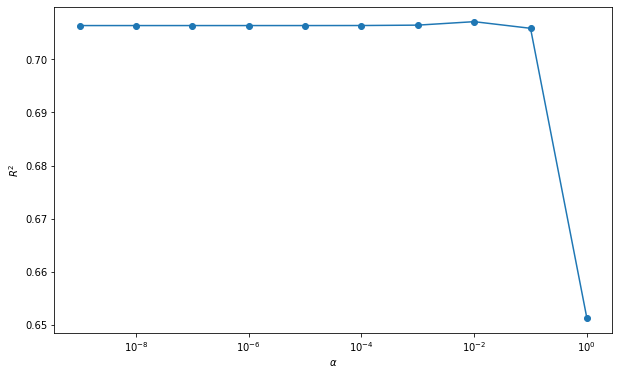

In [ ]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise

Add `PolynomialFeatures` to this `Pipeline`, and re-run the cross validation with the `PolynomialFeatures` added.

**Hint #1:** pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.
Adding the polynomial features is better to be placed before standard scaling so that muliplication and squares values are better 

**Hint #2:** you should see a significant increase in cross validation accuracy from doing this

In [ ]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
         ("make_higher_degree", pf),                 
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)
    

If you store the results in a list called `scores`, the following will work:

In [ ]:
scores

[0.8370717288829701,
 0.8326948144310432,
 0.8286529559925637,
 0.8233523152510991,
 0.8167906006184344,
 0.810900248915436,
 0.8034074560144936,
 0.7982062979349632,
 0.7905903084402228,
 0.7792012048156848,
 0.7631274541298403,
 0.7436899702283892,
 0.7247567692648977,
 0.7078517759504638,
 0.6868696898940607,
 0.6540332780702032,
 0.600898452609131,
 0.5151125189903576,
 0.3773695477866673,
 0.15638110822737483]

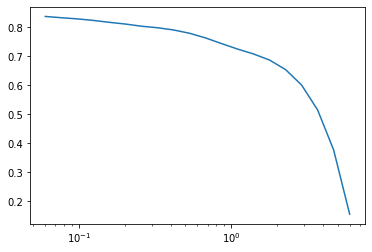

In [ ]:
plt.semilogx(alphas, scores);

In [ ]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.9134777735196521

In [ ]:
best_estimator.named_steps["lasso_regression"].coef_

array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -1.00309168e+00,  3.32679107e+00, -1.01840878e+00,
       -2.56161421e+00,  1.12778302e+00, -1.72266155e+00, -5.37088506e-01,
        4.39555878e-01, -3.39542586e+00,  7.22387712e-02,  0.00000000e+00,
        0.00000000e+00,  3.53653554e+00, -0.00000000e+00,  3.72285440e-01,
        0.00000000e+00,  0.00000000e+00, -5.49528703e-01, -0.00000000e+00,
       -0.00000000e+00, -4.05522485e-02,  2.25864611e-01,  1.78508858e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.50874606e-02,
       -0.00000000e+00, -2.07295802e-01, -0.00000000e+00,  3.71781995e-01,
        0.00000000e+00, -0.00000000e+00, -5.89531100e-02,  3.47180625e-01,
        0.00000000e+00,  9.23666274e-01,  3.48873365e-01,  7.29463442e-02,
        0.00000000e+00,  0.00000000e+00,  7.68485586e-02, -7.21083596e-01,
        0.00000000e+00, -5.98542558e-01,  4.18420677e-01, -7.98165728e-01,
       -7.25062683e-01,  

In the coefficients above , you can see how generalizing our model gave us less coefficients and this will help to generalize to new incoming data .  

## Ridge Regression 

### Exercise

Do the same, but with `Ridge` regression 

Which model, `Ridge` or `Lasso`, performs best with its optimal hyperparameters on the Boston dataset?

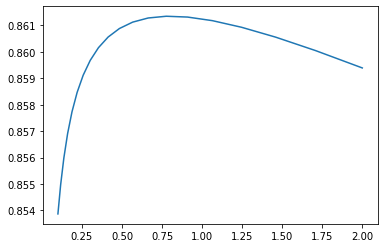

In [ ]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(0.1, 2, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("polynomial_features", pf),
        ("scaler", s),
        
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

## Interpretability 

### Exercise:

Now, for whatever your best overall hyperparameter was: 

* Standardize the data
* Fit and predict on the entire dataset
* See what the largest coefficients were
    * Hint: use 
    ```python
    dict(zip(model.coef_, pf.get_feature_names()))
    ```
    for your model `model` to get the feature names from `PolynomialFeatures`.
    
    Then, use
    ```python
    dict(zip(list(range(len(X.columns.values))), X.columns.values))
    ```
    
    to see which features in the `PolynomialFeatures` DataFrame correspond to which columns in the original DataFrame.


In [ ]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([ ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("scaler", s),
                   
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265.49820369624604, tolerance: 4.2716295415019765
  positive)


0.8814581025430906

We want to zip values of column names and coeficients learnt from the model to see what values are contributing to the target . 

In [ ]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features = X.columns),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [ ]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [ ]:
col_names_dict

{0: 'CRIM',
 1: 'ZN',
 2: 'INDUS',
 3: 'CHAS',
 4: 'NOX',
 5: 'RM',
 6: 'AGE',
 7: 'DIS',
 8: 'RAD',
 9: 'TAX',
 10: 'PTRATIO',
 11: 'B',
 12: 'LSTAT'}

In [ ]:
df_importances.sort_values(by=1)

,0,1
73,RM TAX,-4.934846
76,RM LSTAT,-3.936603
94,RAD LSTAT,-3.167028
8,DIS,-2.914693
49,INDUS LSTAT,-2.536566
...,...,...
17,CRIM CHAS,2.108712
96,TAX PTRATIO,2.381174
9,RAD,3.900466
104,LSTAT^2,4.856117


## Grid Search CV

To do cross-validation, we used two techniques:
- use `KFolds` and manually create a loop to do cross-validation
- use `cross_val_predict` and `score` to get a cross-valiated score in a couple of lines.

To do hyper-parameter tuning, we see a general pattern:
- use `cross_val_predict` and `score` in a manually written loop over hyperparemeters, then select the best one.

Perhaps not surprisingly, there is a function that does this for us -- `GridSearchCV`

In [ ]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([  ("polynomial_features", PolynomialFeatures()),
                      ("scaler", StandardScaler()),
                      ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [ ]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomial_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('ridge_regression',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercep...
        5.27924796,  5.58051751,  5.8989

In [ ]:
grid.best_score_, grid.best_params_

(0.8546333782070428,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 4.0})

In [ ]:
y_predict = grid.predict(X)

In [ ]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.8964707714558113

In [ ]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([ 0.00000000e+00,  2.47147038e-01, -1.18377806e+00,  1.11700133e+00,
        1.02268931e+00,  1.11573592e+00,  2.63515343e+00,  1.60400844e+00,
       -2.44378403e+00,  2.67549673e+00,  1.18120641e+00,  3.00931414e-01,
        7.17164316e-01,  5.46697603e-01,  1.16368605e+00,  2.78583120e-01,
        4.15770986e-01,  2.45396270e+00, -1.07012228e+00, -8.15812777e-01,
       -2.95036466e-01, -8.26480829e-01, -4.23552596e-01, -4.33022591e-02,
        8.34930099e-02, -4.92838202e-01,  5.12447325e-01,  5.88355149e-01,
       -3.50662224e-01, -1.39184102e-01, -2.99737738e-01,  1.02696466e+00,
        1.47705864e-02, -6.87593891e-01, -3.12176710e-01,  1.26476807e+00,
        1.01258007e+00, -5.51925730e-01, -8.62269698e-01,  8.78832853e-01,
        6.75975245e-02,  5.91362874e-01, -1.45086000e+00,  1.09286634e+00,
       -7.69112663e-01,  1.16978387e+00,  1.29460196e+00, -7.36888615e-01,
        7.29205860e-01, -2.44086792e+00,  1.02268931e+00, -2.26162754e+00,
       -2.56091292e+00,  

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.00506695, 0.00291546, 0.00365591, 0.00297983, 0.00300916,
        0.00292937, 0.00304977, 0.00303372, 0.00373578, 0.00312908,
        0.00307186, 0.00314458, 0.00302219, 0.00335113, 0.00305176,
        0.0028708 , 0.00292794, 0.00287437, 0.00286301, 0.00280865,
        0.0031147 , 0.00333699, 0.0028491 , 0.00295885, 0.00353654,
        0.00311009, 0.00297435, 0.00316787, 0.00359678, 0.00300558,
        0.01417406, 0.00873415, 0.00623107, 0.0057416 , 0.00641966,
        0.00569614, 0.00652893, 0.00604105, 0.00633089, 0.00612736,
        0.00582377, 0.00628352, 0.01526682, 0.01500924, 0.01705432,
        0.00570353, 0.00625523, 0.00575288, 0.00627844, 0.00770903,
        0.01480071, 0.01595521, 0.01729608, 0.0137337 , 0.01383408,
        0.01584355, 0.01415785, 0.0150106 , 0.0165019 , 0.01583687,
        0.03043906, 0.01596967, 0.02650038, 0.03055422, 0.01483655,
        0.01532674, 0.02176714, 0.01539723, 0.03232733, 0.03400771,
        0.02322634, 0.02159484,

## Summary

1. We can manually generate folds by using `KFolds`
2. We can get a score using `cross_val_predict(X, y, cv=KFoldObject_or_integer)`. 
   This will produce the out-of-bag prediction for each row.
3. When doing hyperparameter selection, we should be optimizing on out-of-bag scores. This means either using `cross_val_predict` in a loop, or ....
4. .... use `GridSearchCV`. GridSearchCV takes a model (or pipeline) and a dictionary of parameters to scan over. It finds the hyperparameter set that has the best out-of-sample score on all the parameters, and calls that it's "best estimator". It then retrains on all data with the "best" hyper-parameters.

### Extensions

Here are some additional items to keep in mind:
* There is a `RandomSearchCV` that tries random combination of model parameters. This can be helpful if you have a prohibitive number of combinations to test them all exhaustively.
* KFolds will randomly select rows to be in the training and test folds. There are other methods (such as `StratifiedKFolds` and `GroupKFold`, which are useful when you need more control over how the data is split (e.g. to prevent data leakage). You can create these specialized objects and pass them to the `cv` argument of `GridSearchCV`.

---
### Machine Learning Foundation (C) 2020 IBM Corporation